# Import liabraries

In [14]:
# !pip install scikit-image
# !pip install spotipy

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import skimage
from skimage import io

# Data Cleaning and Preprocessing

In [17]:
def clean_dataframe(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Drop the "Unnamed: 0" column
    df = df.drop("Unnamed: 0", axis=1)

    # Check for missing values
    print(df.isna().sum())

    # Drop missing values
    df = df.dropna()

    # Drop duplicate rows
    df = df.drop_duplicates()

    # Keep only the first occurrence of each track name
    df.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

    # Convert the 'explicit' column to int type
    df['explicit'] = df['explicit'].astype(int)

    return df

In [19]:
df = clean_dataframe("SpotifyData.csv")

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


# EDA

C:\Users\Silvia\AppData\Local\Temp\ipykernel_17996\245578015.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['popularity'],ax=ax[0,0])
C:\Users\Silvia\AppData\Local\Temp\ipykernel_17996\245578015.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['duration_ms'],ax=ax[0,1])
C:\Users\Si

<Axes: xlabel='time_signature', ylabel='Density'>

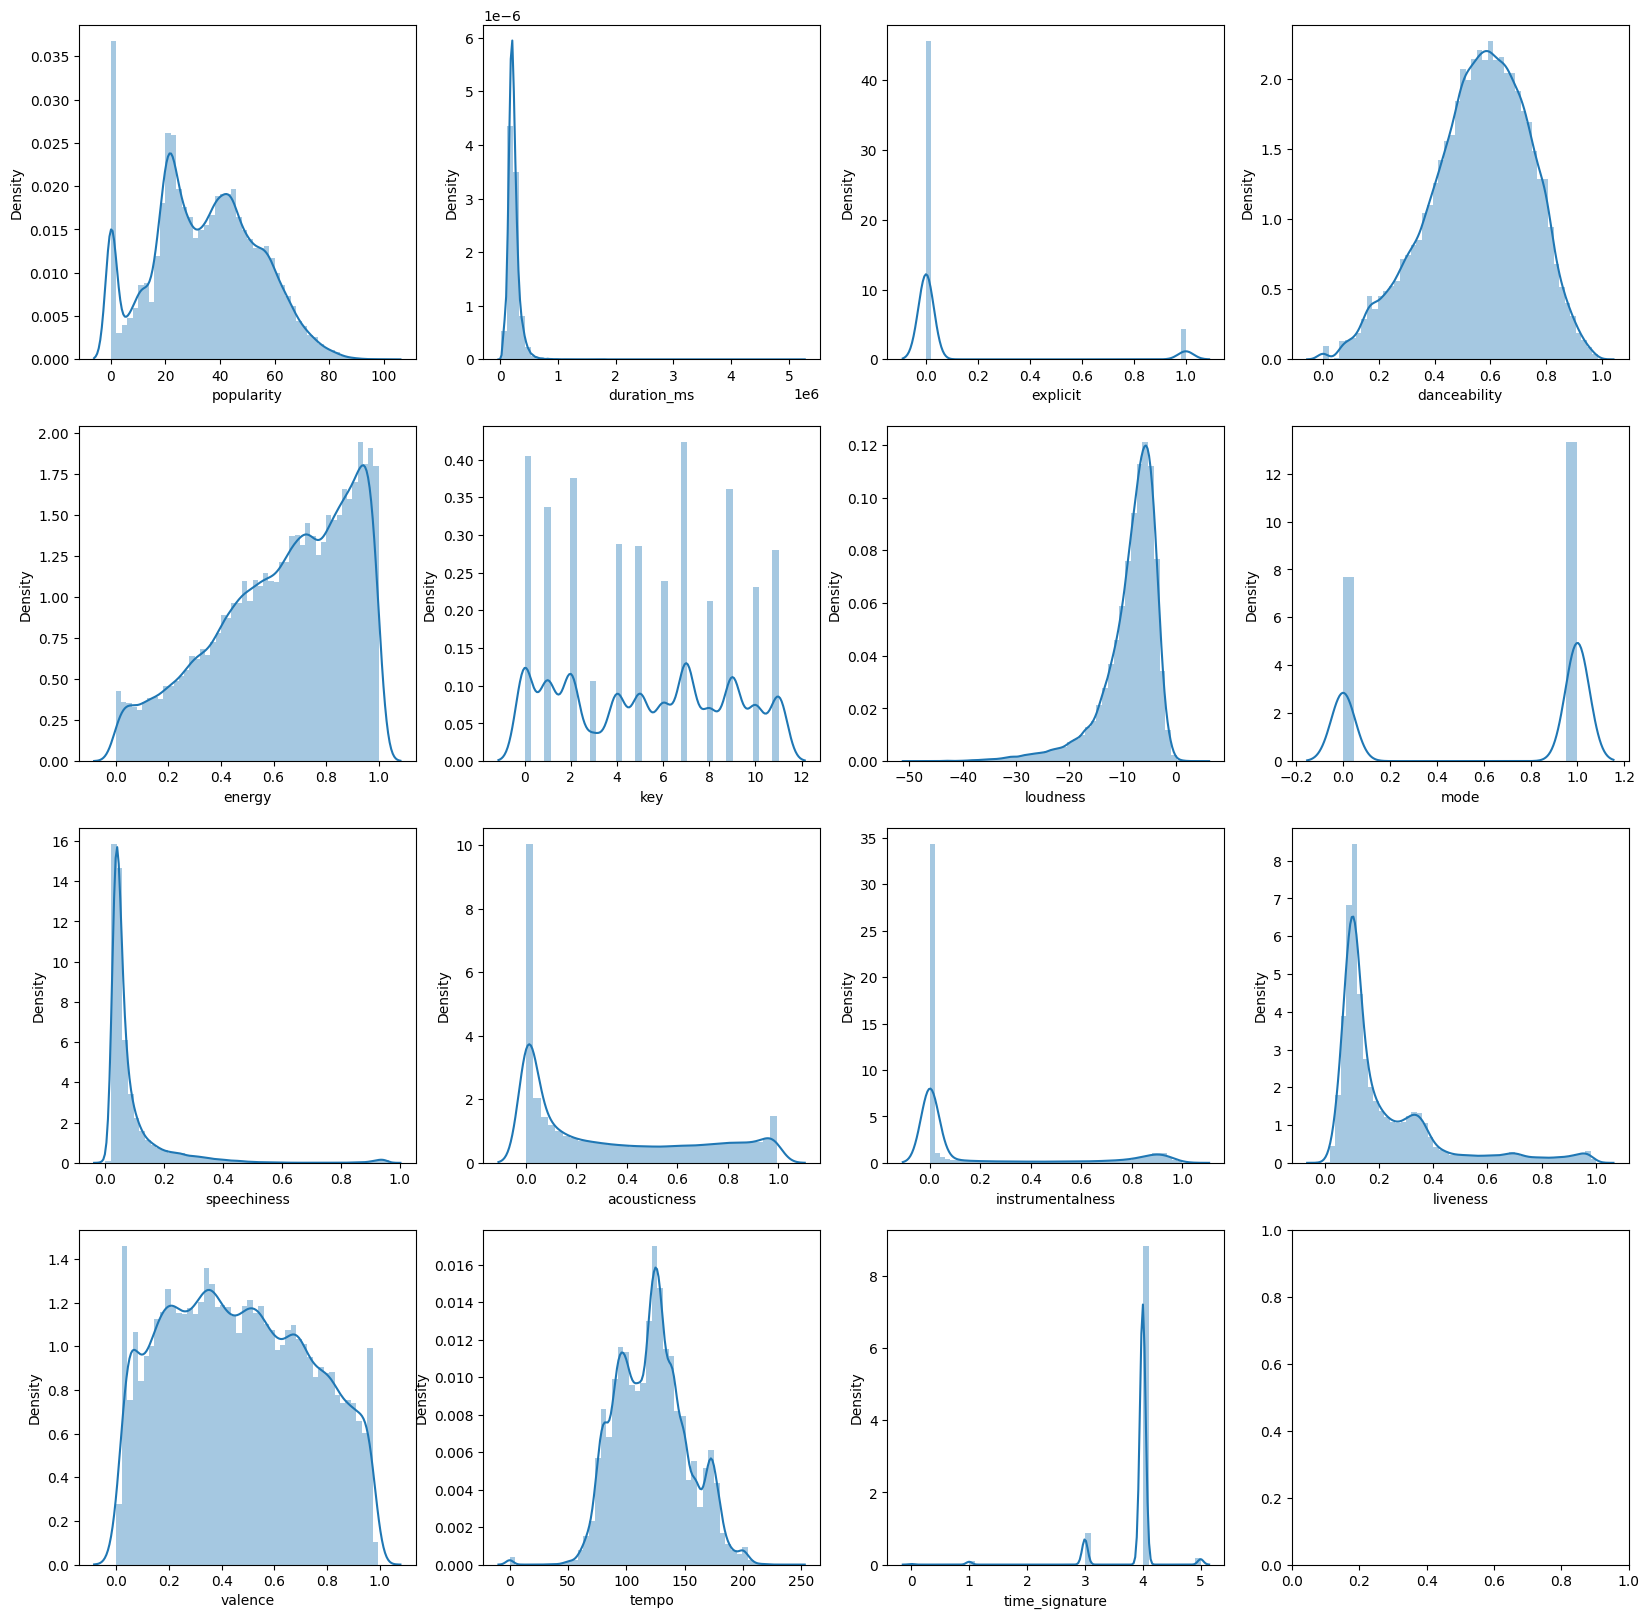

In [20]:
#Visualisation of Variability for each column in the dataframe
fig,ax = plt.subplots(4,4,figsize=(20,20))

sns.distplot(df['popularity'],ax=ax[0,0])
sns.distplot(df['duration_ms'],ax=ax[0,1])
sns.distplot(df['explicit'],ax=ax[0,2])
sns.distplot(df['danceability'],ax=ax[0,3])
sns.distplot(df['energy'],ax=ax[1,0])
sns.distplot(df['key'],ax=ax[1,1])
sns.distplot(df['loudness'],ax=ax[1,2])
sns.distplot(df['mode'],ax=ax[1,3])
sns.distplot(df['speechiness'],ax=ax[2,0])
sns.distplot(df['acousticness'],ax=ax[2,1])
sns.distplot(df['instrumentalness'],ax=ax[2,2])
sns.distplot(df['liveness'],ax=ax[2,3])
sns.distplot(df['valence'],ax=ax[3,0])
sns.distplot(df['tempo'],ax=ax[3,1])
sns.distplot(df['time_signature'],ax=ax[3,2])

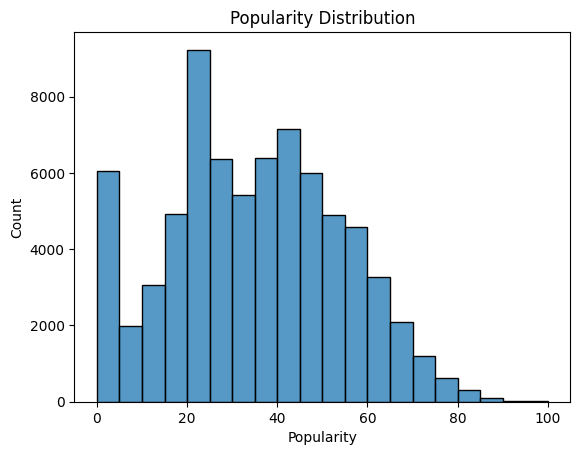

In [21]:
sns.histplot(df['popularity'], bins=20)
plt.title('Popularity Distribution')
plt.xlabel('Popularity')
plt.ylabel('Count')
plt.show()

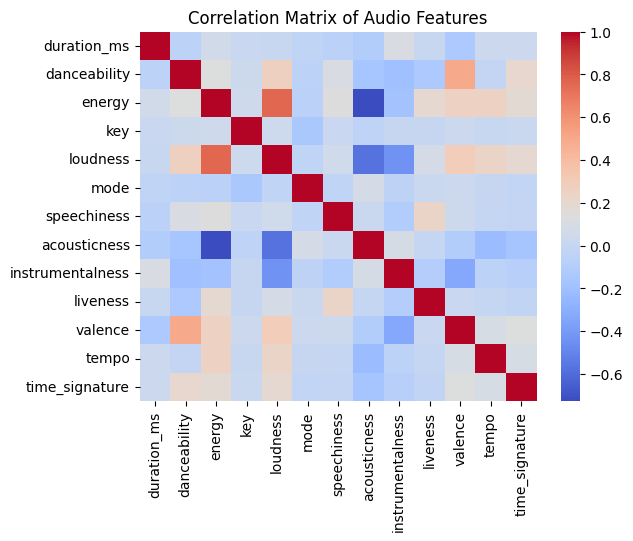

In [25]:
corr = df.drop(['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'explicit', 'track_genre'], axis=1).corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Correlation Matrix of Audio Features')
plt.show()

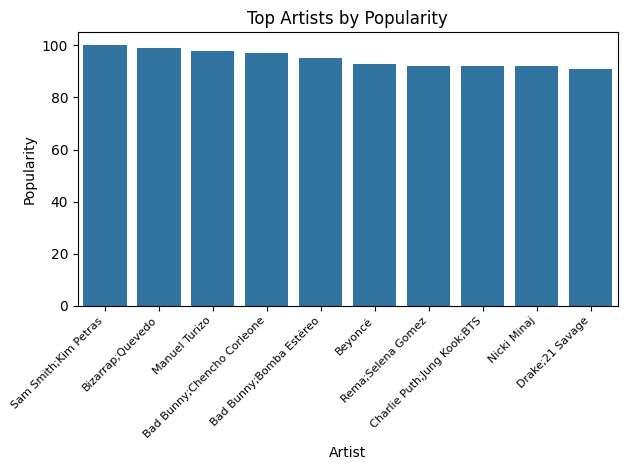

In [26]:
top_artists = df.groupby('artists')['popularity'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top Artists by Popularity')
plt.xlabel('Artist')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.xticks(fontsize=8, ha='right')
plt.tight_layout()
plt.show()

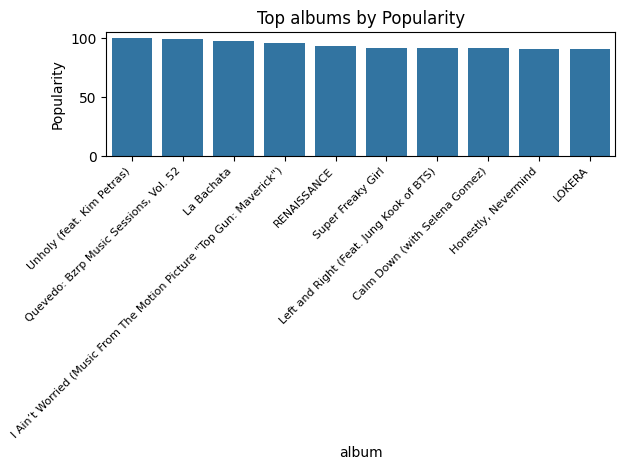

In [27]:
top_artists = df.groupby('album_name')['popularity'].mean().sort_values(ascending=False)[:10]
sns.barplot(x=top_artists.index, y=top_artists.values)
plt.title('Top albums by Popularity')
plt.xlabel('album')
plt.ylabel('Popularity')
plt.xticks(rotation=45)
plt.xticks(fontsize=8, ha='right')
plt.tight_layout()
plt.show()

In [28]:
df_hist = df.drop(['track_name', 'track_id', 'artists', 'album_name'], axis=1)
df_hist

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,22,305454,0,0.331,0.1710,1,-15.668,1,0.0350,0.9200,0.022900,0.0679,0.3270,132.147,3,world-music
113995,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music


In [29]:
def generate_histograms(df):
    # get the number of columns in the DataFrame
    num_cols = len(df.columns)
    # calculate the number of rows needed based on the number of columns
    num_rows = (num_cols + 1) // 2
    # create a grid of subplots
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(10, num_rows*5))
    axs = axs.ravel()
    # loop through each column in the DataFrame
    for i, col in enumerate(df.columns):
        # create a histogram for the column in the appropriate subplot
        axs[i].hist(df[col])
        # set the title, x-label, and y-label
        axs[i].set_title('Histogram of {}'.format(col))
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('Frequency')
    # display the subplots
    plt.show()

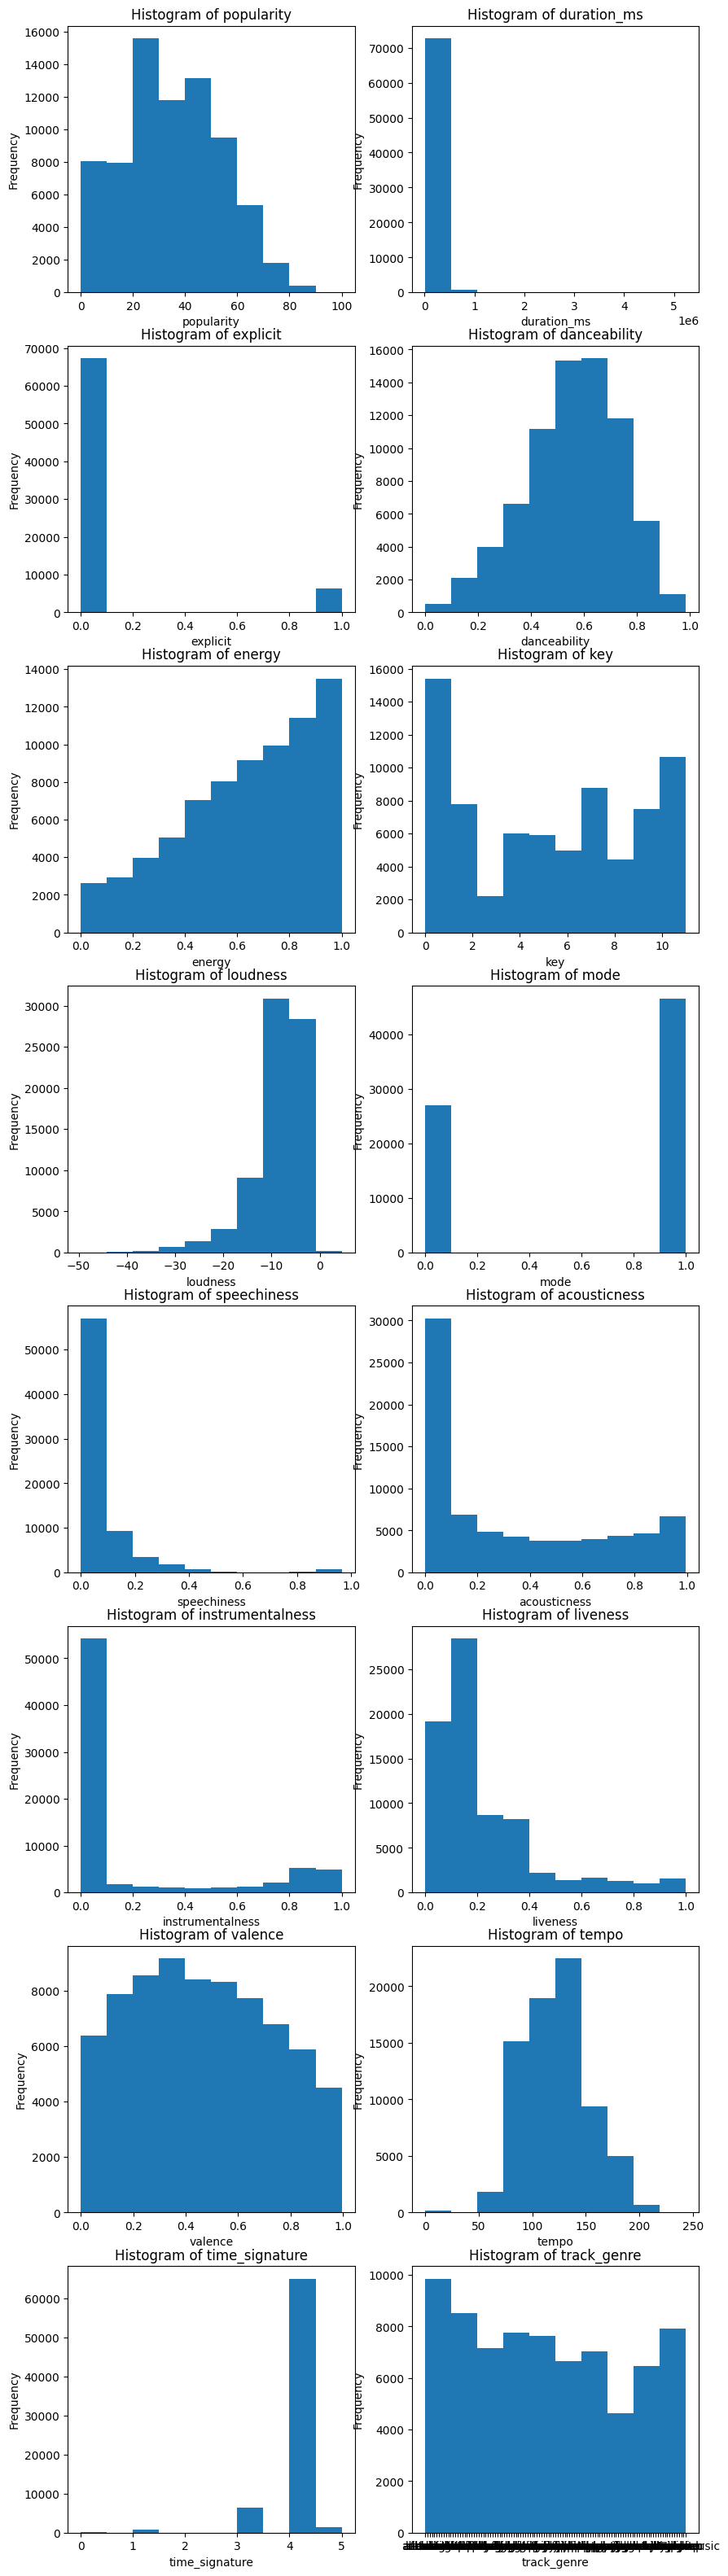

In [30]:
generate_histograms(df_hist)

<Axes: >

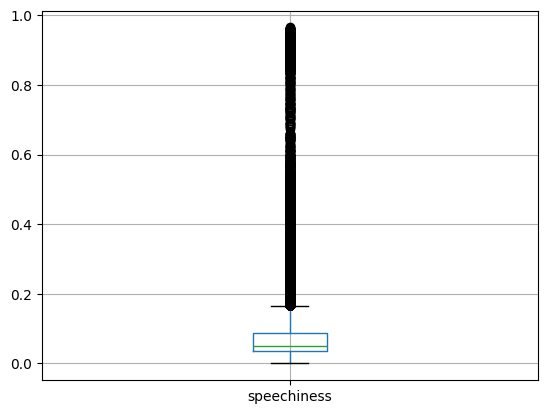

In [31]:
df[['speechiness']].boxplot()

# Prediction Model

## XG Boost model with 3 popularity labels

In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

In [36]:
# Load data
data = pd.read_csv('spotifyData.csv')

data.isnull().sum()
data = data.dropna()
data = data.drop(['Unnamed: 0', 'track_id','artists','album_name','track_name','track_genre'], axis=1)

# Convert popularity to categorical label
data['popularity_label'] = pd.cut(data['popularity'], bins=[-1,50,75,100], labels=[0,1,2])

# Select features and target
X = data[['acousticness', 'duration_ms','danceability', 'energy', 'explicit','instrumentalness', 'liveness', 'loudness','speechiness', 'tempo', 'valence']]
y = data['popularity_label']


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create XGBoost model
model = XGBClassifier()

# Train model
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate accuracy and f1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print("F1 score:", f1)


Accuracy: 0.773859649122807
F1 score: 0.7048459747264632


## XG Boost m

## Decision Tree model with three popularity labels

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [38]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])
df['explicit'] = le.fit_transform(df['explicit'])
df['popularity_label'] = 0
df.loc[(df['popularity'] > 50) & (df['popularity'] <= 75), 'popularity_label'] = 1
df.loc[(df['popularity'] > 75) & (df['popularity'] <= 100), 'popularity_label'] = 2

In [39]:
x = df.drop(['popularity_label', 'popularity'],axis=1)
y = df['popularity_label']

In [40]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.5, random_state=42)

In [41]:
# the first decision tree model
decision_tree = DecisionTreeClassifier(random_state=42,class_weight='balanced')
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [42]:
y_train_predict_dt = decision_tree.predict(x_train)
y_test_predict_dt = decision_tree.predict(x_test)

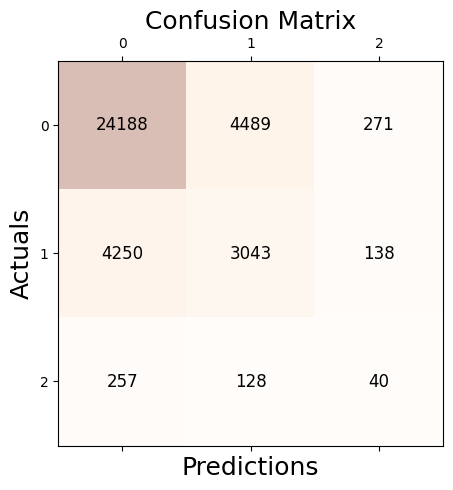

In [43]:
# confusion matrix of the first decision tree model
confusion_matrix_dt = confusion_matrix(y_test, y_test_predict_dt)
# Print the confusion matrix using Matplotlib
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix_dt, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix_dt.shape[0]):
    for j in range(confusion_matrix_dt.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix_dt[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [44]:
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

In [45]:
# results of the first decision tree model
print('F-1 Score:',f1_score(y_test, y_test_predict_dt, average = 'weighted'))
print('Accuracy:', metrics.accuracy_score(y_test, y_test_predict_dt))
print('Precision:',metrics.precision_score(y_test, y_test_predict_dt,average='weighted'))
print('Recall:',metrics.recall_score(y_test, y_test_predict_dt,average='weighted'))

F-1 Score: 0.7425792970427859
Accuracy: 0.7409792413868058
Precision: 0.7442438893153355
Recall: 0.7409792413868058


## Decision Tree Model with oversampling method

In [48]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

In [49]:
# Apply SMOTE to the training set
sm = SMOTE(random_state=42)
x_train_res, y_train_res = sm.fit_resample(x_train, y_train)
x_test_res, y_test_res = sm.fit_resample(x_test, y_test)

# Check the shape of the balanced dataset
print(x_train_res.shape, y_train_res.shape, x_test_res.shape, y_test_res.shape)

(85770, 19) (85770,) (86844, 19) (86844,)


In [50]:
decision_tree_oversample = DecisionTreeClassifier(random_state=42)
decision_tree_oversample.fit(x_train_res, y_train_res)

DecisionTreeClassifier(random_state=42)

In [51]:
y_train_predict_dt_oversample = decision_tree_oversample.predict(x_train_res)
y_test_predict_dt_oversample = decision_tree_oversample.predict(x_test_res)

In [52]:
# results of decision tree model with oversampling
print('F-1 Score(oversample):',f1_score(y_test_res, y_test_predict_dt_oversample, average = 'weighted'))
print('Accuracy(oversample):', metrics.accuracy_score(y_test_res, y_test_predict_dt_oversample))
print('Precision(oversample):',metrics.precision_score(y_test_res, y_test_predict_dt_oversample,average='weighted'))
print('Recall(oversample):',metrics.recall_score(y_test_res, y_test_predict_dt_oversample,average='weighted'))

F-1 Score(oversample): 0.46046591630106115
Accuracy(oversample): 0.48370641610243653
Precision(oversample): 0.5131075393128841
Recall(oversample): 0.48370641610243653


## Decision Tree model with two popularity labels

In [53]:
df_2 = df.copy()
df_2 = df_2.drop('popularity_label', axis=1)
df['popularity_label'] = 0
df_2.loc[df_2['popularity'] <75, 'popularity_label'] = 0
df_2.loc[df_2['popularity'] >= 75, 'popularity_label'] = 1
df_2

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,popularity_label
0,51599,9623,7428,11741,73,230666,0,0.676,0.4610,1,...,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,0,0.0
1,45745,3046,13573,22528,55,149610,0,0.420,0.1660,1,...,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,0,0.0
2,16228,11524,35866,60774,57,210826,0,0.438,0.3590,0,...,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,0,0.0
3,63964,13790,7863,9580,71,201933,0,0.266,0.0596,0,...,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,0,0.0
4,56010,4880,15481,25689,82,198853,0,0.618,0.4430,2,...,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113994,42760,15387,12827,21373,22,305454,0,0.331,0.1710,1,...,1,0.0350,0.9200,0.022900,0.0679,0.3270,132.147,3,112,0.0
113995,20719,20908,62,53329,21,384999,0,0.172,0.2350,5,...,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,112,0.0
113996,16069,20908,62,65090,22,385000,0,0.174,0.1170,0,...,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,112,0.0
113997,65761,4601,4618,38207,22,271466,0,0.629,0.3290,0,...,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,112,0.0


In [54]:
x_2 = df_2.drop(['popularity_label', 'popularity'],axis=1)
y_2 = df_2['popularity_label']

In [55]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, train_size=0.5, random_state=42)

In [56]:
decision_tree_3 = DecisionTreeClassifier(random_state=42,class_weight='balanced')
decision_tree_3.fit(x_train_2, y_train_2)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [57]:
y_train_predict_dt_3 = decision_tree_3.predict(x_train_2)
y_test_predict_dt_3 = decision_tree_3.predict(x_test_2)

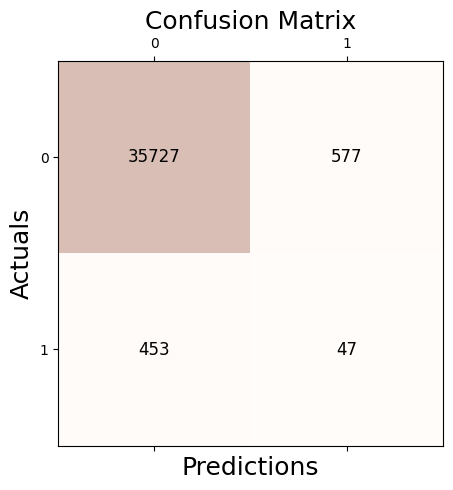

In [58]:
confusion_matrix_dt_3 = confusion_matrix(y_test_2, y_test_predict_dt_3)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix_dt_3, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix_dt_3.shape[0]):
    for j in range(confusion_matrix_dt_3.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix_dt_3[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
# results of the second decision tree model
print('F-1 Score:',f1_score(y_test_2, y_test_predict_dt_3, average = 'weighted'))
print('accuracy:',metrics.accuracy_score(y_test_2, y_test_predict_dt_3))
print('precision:',metrics.precision_score(y_test_2, y_test_predict_dt_3,average='weighted'))
print('Recall:',metrics.recall_score(y_test, y_test_predict_dt_3,average='weighted'))

F-1 Score: 0.9735336899413262
accuracy: 0.9720139115313553
precision: 0.9750871559050465
Recall: 0.7805401586784045


## Random Forest Model with three popularity labels

In [60]:
# random forest
random_forest = RandomForestClassifier(n_estimators=1000, class_weight = 'balanced')
random_forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [61]:
y_train_predict_rf = random_forest.predict(x_train)
y_test_predict_rf = random_forest.predict(x_test)

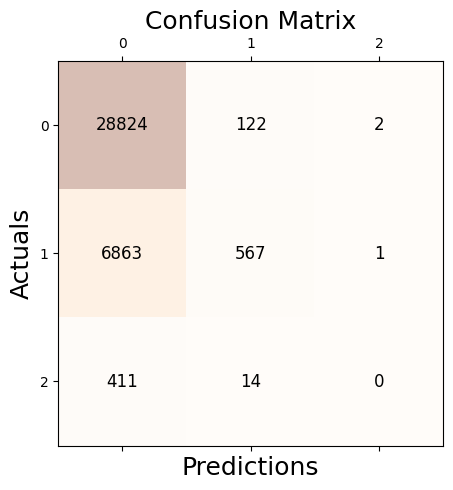

In [62]:
# confusion matrix of the first random forest model
confusion_matrix_rf = confusion_matrix(y_test, y_test_predict_rf)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix_rf, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix_rf.shape[0]):
    for j in range(confusion_matrix_rf.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix_rf[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [63]:
# results of the first random forest model
print('F-1 Score:',f1_score(y_test, y_test_predict_rf, average = 'weighted'))
print('accuracy:', metrics.accuracy_score(y_test, y_test_predict_rf))
print('Precision:',metrics.precision_score(y_test, y_test_predict_rf,average='weighted'))
print('Recall:', metrics.recall_score(y_test, y_test_predict_rf,average='weighted'))

F-1 Score: 0.7252362146740273
accuracy: 0.798581675904793
Precision: 0.7908977016024447
Recall: 0.798581675904793


## Random Forest model with two popularity labels

In [64]:
random_forest_2 = RandomForestClassifier(n_estimators=1000, class_weight = 'balanced')
random_forest_2.fit(x_train_2, y_train_2)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [65]:
y_train_predict_rf_2 = random_forest_2.predict(x_train_2)
y_test_predict_rf_2 = random_forest_2.predict(x_test_2)

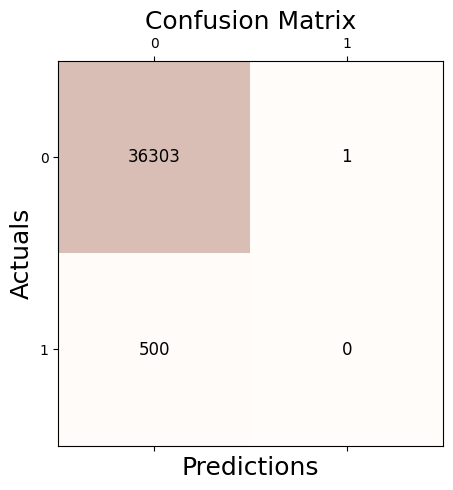

In [66]:
# confusion matrix of the second random forest model
confusion_matrix_rf_2 = confusion_matrix(y_test_2, y_test_predict_rf_2)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confusion_matrix_rf_2, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(confusion_matrix_rf_2.shape[0]):
    for j in range(confusion_matrix_rf_2.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix_rf_2[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [67]:
# results of the second random forest model
print('F-1 Score:',f1_score(y_test, y_test_predict_rf_2, average = 'weighted'))
print('accuracy:', metrics.accuracy_score(y_test, y_test_predict_rf_2))
print('Precision:',metrics.precision_score(y_test, y_test_predict_rf_2,average='weighted'))
print('Recall:', metrics.recall_score(y_test, y_test_predict_rf_2,average='weighted'))

F-1 Score: 0.6925557451716707
accuracy: 0.7865177698076296
Precision: 0.6186483819360177
Recall: 0.7865177698076296


c:\Users\Silvia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Feature Importance of the best model

In [68]:
importance = random_forest_2.feature_importances_
# Print the feature importance scores
for i,v in enumerate(importance):
    print('Feature:', x.columns[i], 'Score:', v)

Feature: track_id Score: 0.041498156245137724
Feature: artists Score: 0.05068888635705107
Feature: album_name Score: 0.04471932209500051
Feature: track_name Score: 0.052212538669752936
Feature: duration_ms Score: 0.07070291043250469
Feature: explicit Score: 0.023675250453776563
Feature: danceability Score: 0.0653431072661515
Feature: energy Score: 0.07416138407879264
Feature: key Score: 0.02175625796231085
Feature: loudness Score: 0.07211543296456784
Feature: mode Score: 0.00443258832598468
Feature: speechiness Score: 0.05658267723772752
Feature: acousticness Score: 0.0749959901758935
Feature: instrumentalness Score: 0.07188778152586153
Feature: liveness Score: 0.054257638612671515
Feature: valence Score: 0.05365803025227642
Feature: tempo Score: 0.04577349613675514
Feature: time_signature Score: 0.004095572613807259
Feature: track_genre Score: 0.11744297859397618


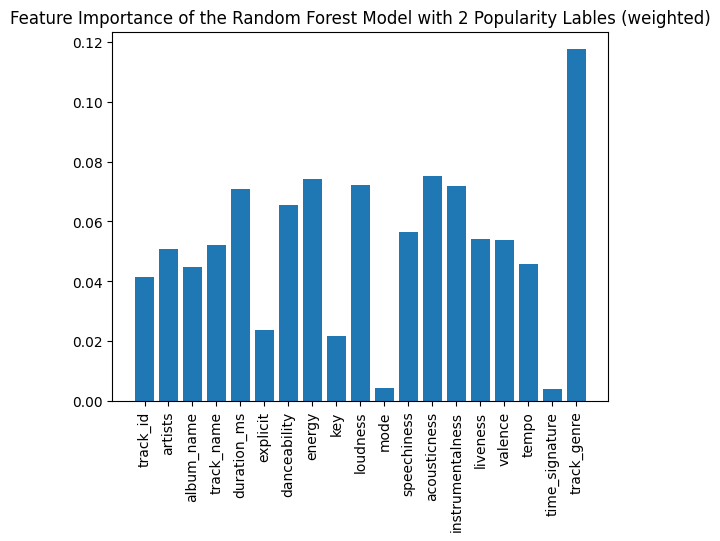

In [69]:
plt.bar(x.columns, importance)
plt.xticks(rotation=90)
plt.title('Feature Importance of the Random Forest Model with 2 Popularity Lables (weighted)')
plt.show()

## Linear regression model

In [71]:
# basic lr with balanced
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
df = pd.read_csv('spotifyData.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
df = df.drop("Unnamed: 0", axis=1)
le = LabelEncoder()
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])
df['explicit'] = le.fit_transform(df['explicit'])
# Define the features and target variable
X = df.drop("popularity", axis=1)
y = df["popularity"]

# Calculate the sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y)

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, sample_weights, test_size=0.5, random_state=42)

# Initialize the linear regression model
lr_model = LinearRegression()

# Fit the model on the training data with sample weights
lr_model.fit(X_train, y_train, sample_weight=weights_train)

# Predict the popularity on the test data
y_pred = lr_model.predict(X_test)

# Calculate the mean squared error and root mean squared error
mse = mean_squared_error(y_test, y_pred, sample_weight=weights_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred, sample_weight=weights_test)
print(lr_model.score(X_test, y_test, sample_weight=weights_test))
# Print the RMSE
print('RMSE:', rmse)
print('R2:', r2)


0.18928362498442242
RMSE: 25.47605116832978
R2: 0.18928362498442242


In [72]:
# Get the most correlated features with the target variable (popularity)
corr_matrix = df.corr().abs()
top_features = corr_matrix['popularity'].sort_values(ascending=False)[:10].index.tolist()

print(top_features)

['popularity', 'instrumentalness', 'loudness', 'speechiness', 'explicit', 'album_name', 'valence', 'danceability', 'track_genre', 'time_signature']


In [75]:
#optize the model by feature selection and remove outliers
from scipy import stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import numpy as np

df = pd.read_csv('spotifyData.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)

# Remove any records with missing values
le = LabelEncoder()
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])
df['explicit'] = le.fit_transform(df['explicit'])

# calculate z-scores for each column
z_scores = stats.zscore(df)

# set threshold for outliers
threshold = 3

# find the index of outliers in each column
outliers = np.where(np.abs(z_scores) > threshold)

# remove outliers from the dataset
df = df.drop(df.index[outliers[0]])
df = df.drop("Unnamed: 0", axis=1)

# rebuild the linear regression model
cols=['instrumentalness', 'loudness', 'speechiness', 'explicit', 'album_name', 'valence', 'danceability', 'track_genre', 'time_signature']

y = df['popularity']
X = df[cols]

# normalize the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Compute class weights to balance the data
# class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
# weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
# Apply oversampling
# oversampler = RandomOverSampler(random_state=42)
# X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Lasso regularization for feature selection
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

# Get the selected features
# selected_features = X.columns[lasso.coef_ != 0]

# # Fit the linear regression model with the selected features
# X_train_selected = X_train[:,lasso.coef_ != 0]
# X_test_selected = X_test[:,lasso.coef_ != 0]

# Fit the linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict the target variable
y_pred = lin_reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("RMSE: ", rmse)
print("R2 Score: ", r2)


MSE:  486.0680810190181
RMSE:  22.046951739844175
R2 Score:  0.027867643730885128


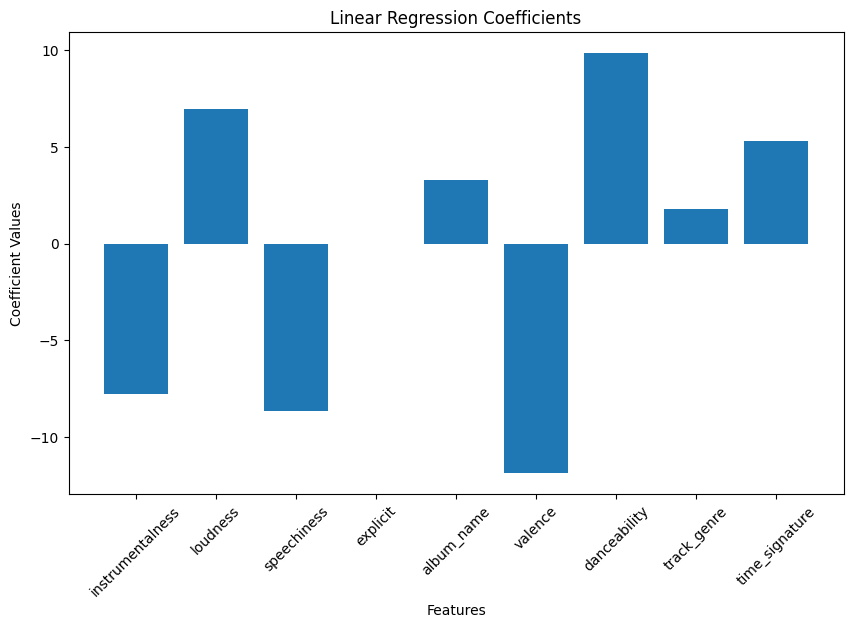

In [76]:
#plot the coeffients
import matplotlib.pyplot as plt

# Get the coefficients and corresponding feature names
coefs = lin_reg.coef_
features = df[cols].columns

# Create a bar plot of the coefficients
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(features, coefs)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Set the plot title and axis labels
ax.set_title('Linear Regression Coefficients')
ax.set_xlabel('Features')
ax.set_ylabel('Coefficient Values')

plt.show()

## Logistic regression model

In [78]:
#label the popularity by 0,1 and 2
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# Load data
df = pd.read_csv('spotifyData.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
df = df.drop("Unnamed: 0", axis=1)

# Encode categorical variables
le = LabelEncoder()
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])
df['explicit'] = le.fit_transform(df['explicit'])

# Group popularity into categories
df['popularity_category'] = pd.cut(df['popularity'], bins=[0, 50,75, 100], labels=['low', 'medium','high'],include_lowest=True)

# Select features and target variable
cols=['instrumentalness', 'loudness', 'speechiness', 'explicit', 'album_name', 'valence', 'danceability', 'track_genre', 'time_signature']
X = df[cols]
y = df['popularity_category']
#oversampling
# ros = RandomOverSampler(random_state=42)
# X, y = ros.fit_resample(X, y)
# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

# Train the logistic regression model

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs',class_weight='balanced')
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = log_reg.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)


Accuracy: 0.7563333333333333
F1 Score: 0.6515053406360186


In [79]:
from itertools import cycle
from sklearn.metrics import roc_auc_score,auc
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape 

(57000, 3)

In [80]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
n_samples, n_features = X.shape
n_classes=3
y_score = log_reg.fit(X_train, y_train).predict_proba(X_test)
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.63


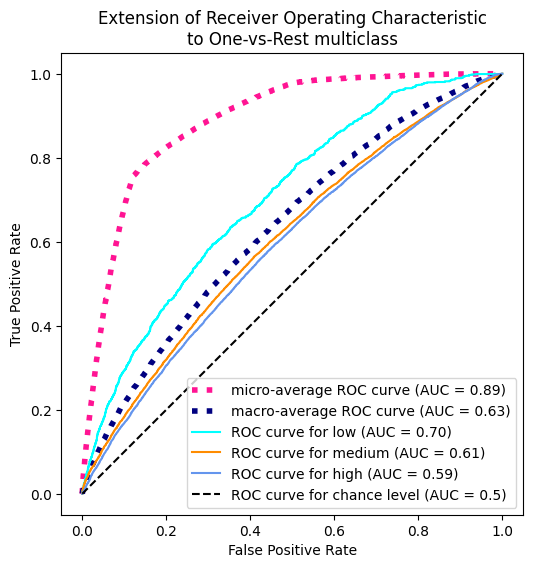

In [81]:
from itertools import cycle
target_names=['low', 'medium','high']
fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass")
plt.legend()
plt.show()

In [83]:
#label by 0 and 1
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
# Load data
df = pd.read_csv('spotifyData.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
df = df.drop("Unnamed: 0", axis=1)

# Encode categorical variables
le = LabelEncoder()
df['artists'] = le.fit_transform(df['artists'])
df['album_name'] = le.fit_transform(df['album_name'])
df['track_id'] = le.fit_transform(df['track_id'])
df['track_name'] = le.fit_transform(df['track_name'])
df['track_genre'] = le.fit_transform(df['track_genre'])
df['explicit'] = le.fit_transform(df['explicit'])

# Group popularity into categories
df['popularity_category'] = pd.cut(df['popularity'], bins=[0, 75, 100], labels=['low','high'],include_lowest=True)

# Select features and target variable
cols=['instrumentalness', 'loudness', 'speechiness', 'explicit', 'album_name', 'valence', 'danceability', 'track_genre', 'time_signature']
X = df[cols]
y = df['popularity_category']

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)


# Train the logistic regression model

log_reg = LogisticRegression(class_weight='balanced')
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = log_reg.score(X_test, y_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)


Accuracy: 0.9786491228070175
F1 Score: 0.9680888789541662


# Recommendation System

## Feature Generation
One-hot Encoding  
Normalization

In [84]:
def one_hot_encoding(df, column, new_name): 
    ''' 
    Create One Hot Encoded features of a specific column
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
    column (str): Column to be processed
    new_name (str): new column name to be used
        
    Output: 
    tf_df: One-hot encoded features 
    '''
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df

In [85]:
def create_feature_set(df):
    '''
    Process spotify df to create a final set of features that will be used to generate recommendations
    ---
    Input: 
    df (pandas dataframe): Spotify Dataframe
            
    Output: 
    final (pandas dataframe): Final set of features 
    '''

    # One-hot Encoding
    genre_ohe = one_hot_encoding(df, 'track_genre', 'genre_encode')

    # Normalization
    feature_cols = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 
                'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature']
    scaler = MinMaxScaler()
    normalized_df =scaler.fit_transform(df[feature_cols])
    normalized_df = pd.DataFrame(normalized_df, columns=feature_cols)

    # Concatenate all features
    final = pd.concat([normalized_df, genre_ohe], axis=1)
    
    return final

## content_based recommendation system
cosine similarity

In [86]:
def generate_recommendation(track_name, model_type):
    index=indices[track_name]
    score=list(enumerate(model_type[index]))
    similarity_score = sorted(score,key = lambda x:x[1],reverse = True)
    similarity_score = similarity_score[1:11]
    top_songs_index = [i[0] for i in similarity_score]
    top_songs=sample_df['track_name'].iloc[top_songs_index]
    return top_songs

## spotify api

In [89]:
# Here need to use the spotify api to save the client id and client secret as a text file.
with open('spotify_api.txt', 'r') as file:
    client_id = file.readline().strip()
    client_secret = file.readline().strip()

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

## output df

In [102]:
def create_outputs(recommend_playlist_name):
    playlist = []
    for name in recommend_playlist_name:
        results = sp.search(q=name, type='track', limit=1)
        if results['tracks']['total'] > 0:
            for ix, i in enumerate(results['tracks']['items']):
                playlist.append({
                'artist': i['artists'][0]['name'],
                'name': i['name'],
                'id': i['id'],
                'url': i['album']['images'][1]['url']
                })
        else:
            print('No results found for track:', name)
    return playlist

## visulization

In [91]:
def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns) + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

## Example of recommendation system
Only use 10000 data from our dataset (because the full dataset is to computional consuming)

In [93]:
df = clean_dataframe("spotifyData.csv")
random_state = 42
sample_df = df.sample(n=10000, random_state=random_state)
sample_df

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
50681,2gpz5SQb1NEPPxjbSglAZK,Pappo,Buscando un Amor,Trabajo Forzado,23,248066,0,0.547,0.6990,9,-4.634,1,0.0357,0.021300,0.008350,0.1310,0.622,75.814,4,heavy-metal
48699,3oYj1UaQtkX0R9iuaV2jMj,Eterna Inocencia,No bien abran las flores,Hojas Amarillas,31,255905,0,0.576,0.7090,2,-5.722,1,0.0327,0.005140,0.000087,0.1250,0.579,140.003,4,hardcore
94512,2WkjVlKU47qVKyPUehA5eH,SONNY NITEZ,MORNING 2007,MORNING 2007,52,118763,1,0.752,0.4850,5,-10.243,1,0.0432,0.255000,0.000000,0.3420,0.819,95.003,4,sad
721,4XBcShO4h4X55x9yMmyKHL,Allman Brown,1000 Years,Sweetest Thing,54,218502,0,0.546,0.4110,2,-9.308,1,0.0475,0.701000,0.000097,0.0955,0.528,79.785,4,acoustic
50331,7pvMOx4cYIamyNeYLVhTWS,Tren Loco,Venas De Acero,Venas De Acero,25,362520,0,0.534,0.9490,4,-3.948,1,0.0665,0.001020,0.000177,0.5370,0.334,114.988,4,heavy-metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605,1IrPSbGITPaMwMMEXfb2DJ,Ali Farka Touré;Toumani Diabaté,Ali & Toumani,Be Mankan,9,306960,0,0.583,0.2060,4,-12.297,1,0.0416,0.900000,0.380000,0.1230,0.483,123.362,3,afrobeat
83400,6r7FXNO57mlZCBY6PXcZZT,Deorro,Five Hours,Five Hours,61,326887,0,0.880,0.8210,5,-2.545,0,0.1180,0.019700,0.661000,0.2340,0.575,127.907,4,progressive-house
44445,7bu0znpSbTks0O6I98ij0W,The Smashing Pumpkins,Mellon Collie And The Infinite Sadness (Deluxe...,"Tonight, Tonight - Remastered 2012",69,254626,0,0.277,0.6700,6,-9.381,1,0.0376,0.000063,0.751000,0.2370,0.217,148.342,4,grunge
98524,1LZik4eONOZd2wuvHVdbmz,Bebe Neuwirth,Chicago The Musical (New Broadway Cast Recordi...,I Can't Do It Alone (Reprise),24,40533,0,0.334,0.0551,10,-18.918,1,0.0491,0.862000,0.000000,0.1190,0.448,164.618,1,show-tunes


In [94]:
complete_feature_set = create_feature_set(sample_df)
complete_feature_set.head()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,...,genre_encode|spanish,genre_encode|study,genre_encode|swedish,genre_encode|synth-pop,genre_encode|tango,genre_encode|techno,genre_encode|trance,genre_encode|trip-hop,genre_encode|turkish,genre_encode|world-music
0,0.247312,0.053714,0.0,0.557594,0.699,0.818182,0.809185,1.0,0.037226,0.021386,...,False,False,False,False,False,False,False,False,False,False
1,0.333333,0.055569,0.0,0.587156,0.709,0.181818,0.786535,1.0,0.034098,0.005161,...,False,False,False,False,False,False,False,False,False,False
2,0.559140,0.023110,1.0,0.766565,0.485,0.454545,0.692418,1.0,0.045047,0.256024,...,False,False,False,False,False,False,False,False,False,False
3,0.580645,0.046717,0.0,0.556575,0.411,0.181818,0.711883,1.0,0.049531,0.703815,...,False,False,False,False,False,False,False,False,False,False
4,0.268817,0.080803,0.0,0.544343,0.949,0.363636,0.823466,1.0,0.069343,0.001024,...,False,False,False,False,False,False,False,False,False,False


In [95]:
# Create a pandas series with song titles as indices and indices as series values 
indices = pd.Series(sample_df.index, index=sample_df['track_name']).drop_duplicates()

# Create cosine similarity matrix based on given matrix
cosine = cosine_similarity(complete_feature_set)

In [96]:
# Song Recommendations using Cosine Similarity
print("Recommended Songs:")
print(generate_recommendation('Tearz',cosine).values)

Recommended Songs:
['Ailein Duinn (Theme From The Movie "Rob Roy")'
 "Il Giasone, Act 1 Scene 14: Dell'antro magico (Arr. for Countertenor & String Quartet by Eric Mouret)"
 'Verdi: Aida, Act 1: "Mortal, diletto ai numi" (Ramfis, Sacerdoti)'
 'Vissi d\'arte - From "Tosca"' 'Perfect Day'
 'La traviata / Act II: "Alfredo?" "Per Parigi or or partiva"'
 'Polifemo, HelN 31: Alto Giove - Arr. for Voice & Piano'
 'All Love Can Be' "Harry's Game" 'Chromaggia']


In [103]:
recommended_songs = generate_recommendation('Tearz',cosine).values
df_recommended_songs = create_outputs(recommended_songs)
df_recommended_songs

[{'artist': 'Méav',
  'name': 'Ailein Duinn (Theme From The Movie "Rob Roy")',
  'id': '0CsjZr8NeVVbqiQsdRp1Kc',
  'url': 'https://i.scdn.co/image/ab67616d00001e024e36858744024289190c09a6'},
 {'artist': 'Francesco Cavalli',
  'name': "Il Giasone, Act 1 Scene 14: Dell'antro magico (Arr. for Countertenor & String Quartet by Eric Mouret)",
  'id': '2I0kfxKcQTLoer605Q74aQ',
  'url': 'https://i.scdn.co/image/ab67616d00001e02700407ba72352dc479c05705'},
 {'artist': 'Giuseppe Verdi',
  'name': 'Verdi: Aida, Act 1: "Immenso Fthà" - "Mortal, diletto ai numi" (Sacerdotesse, Ramfis, Sacerdoti)',
  'id': '6pj7GsvOjOIICYwIBzGq6H',
  'url': 'https://i.scdn.co/image/ab67616d00001e02b89f96cf511ce0d86cbe5e27'},
 {'artist': 'Filippa Giordano',
  'name': 'Vissi d\'arte - From "Tosca"',
  'id': '4BD6nJHL2wlybO4Sxe4Wkb',
  'url': 'https://i.scdn.co/image/ab67616d00001e02810367516eb78f8881888d59'},
 {'artist': 'Lou Reed',
  'name': 'Perfect Day',
  'id': '4TOMI010Sd4ZAX4aZ5TS85',
  'url': 'https://i.scdn.co/

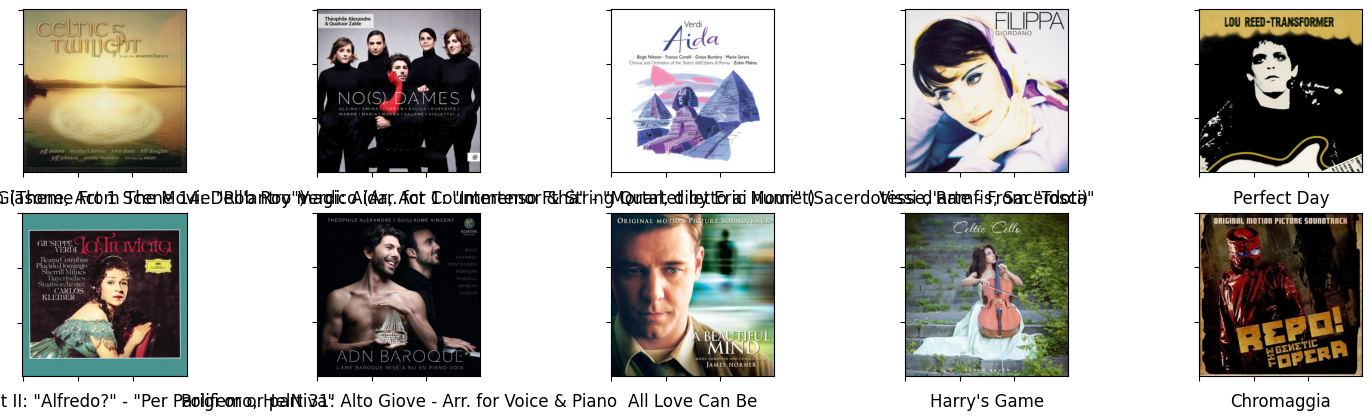

In [105]:
df_recommended_songs = pd.DataFrame(df_recommended_songs)
visualize_songs(df_recommended_songs)